# Interaction Testing for Optimizing Neural Network Performance

Interaction testing is most often used to holistically evaluate large systems with various combinations of parameters. A dataset, when used in the context of a classification model, can also be viewed as such a system. Given a series of explanatory variables `X` and observations `y`, the observations can be seen as a result of a combination of parameters; and classification models seek to glean the connection between these observations and results.

## Dataset Orientation and Initial Exploration

First, let's open our dataset, which comes from Kaggle at the following link: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset


In [56]:
import pandas as pd
import numpy as np

import random

np.random.seed(42)
random.seed(42)

In [57]:
dataset = pd.read_csv("data/diabetes_binary_health_indicators_BRFSS2015.csv")

# display the number of entries and columsn in the dataset
print(dataset.shape)
dataset.head()

(253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


I want to see a plot of each variable against the other to get an idea of the relationship between each variable. To get an idea of these relationships, let's use `seaborn's` built-in ```pairplot``` function.

In [2]:
import seaborn as sns

In [3]:
# this is commented out, as it takes 5+ minutes to run
# view the resulting image as seaborne_plot.png

#sns.pairplot(dataset)

Initial inspection reveals that the response variable (whether an individual has disabetes) is heavily skewed.

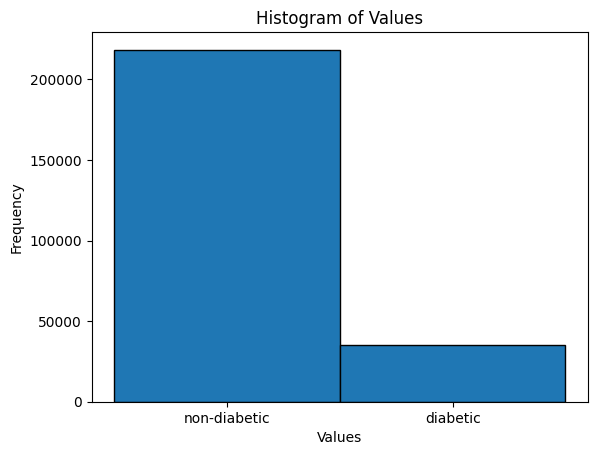

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the histogram
dataset['Diabetes_binary'].plot.hist(bins=2, edgecolor='black')
plt.xlabel('Values')
plt.xticks([0.25, 0.75], ["non-diabetic", "diabetic"])
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

Given the prevalence of certain variables over others, it's likely that a model trained on this data would be more accurate for data points that contain variables that show up more often, likely seeing worse performance on rarer variable occurences.

The following variables are numerical:
* BMI
* GenHlth
* MentHlth
* PhysHlth
* Age
* Education
* Income

The rest are binary.

## Building a Baseline Model

Applying the same foundational principle underlying interaction testing to diabetic diagnoses, it's likely that only a small subset of these health-related interactions are responsible for whether someone has diabetes.

We use transformers to make the data more amenable to the model.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

As we're trying to predict diabetes diagnoses, we'll first drop the ```Diabetes_binary``` column to build our explanatory variables ```X``` and response variable ```y```.

In [7]:
# Define features and target
X = dataset.drop(columns=['Diabetes_binary'])  # Features
y = dataset['Diabetes_binary']  # Target variable

We then further subdivide the explanatory variables into numerical and categorical features.

In [8]:
# Separate numerical and binary columns
numerical_features = ['BMI']
categorical_features = ['GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', ]


We then use ```sklearn```'s built-in ```ColumnTransformer``` to scale the numerical and categorical variables appropiately. Using ```StandardScaler```, we scale all values between ```0``` and `1`, and use `OneHotEncoder` on categorial variables.

In [9]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features),
    ],
    remainder='passthrough' # let binary variables through unaltered
)

# Apply preprocessing to features
X_preprocessed = preprocessor.fit_transform(X)

Finally, we split the data into test and train subsets.

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.25, random_state=42)
print(X_train.shape, y_train.shape)

(190260, 109) (190260,)


## Training Classification Models

### Training a Neural Network on the Full Dataset
With this model cleaned, we're able to implement a neural network to train on the data and hopefully, learn associations within the data. We then build, compile, and train the model.

In [12]:
# Build the model with regularization and dropout
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),  # L2 regularization
    BatchNormalization(),  # Batch normalization
    Dropout(0.5),  # Dropout with 50% rate

    Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),  # L2 regularization
    BatchNormalization(),  # Batch normalization
    Dropout(0.5),  # Dropout with 50% rate
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop if no improvement after 5 epochs
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
)

# Train the model with validation split
history = model.fit(
    X_train, y_train,
    epochs=50,  # Increase epochs; early stopping will handle overtraining
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],  # Include early stopping
    verbose=1
)



c:\Users\Matthew Wanta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4754/4757 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.8055 - loss: 0.6129

KeyboardInterrupt: 

... and then evaluate it.

#### Evaluating the Model Performance
The performance metrics for the model trained on the full dataset include raw accuracy figures, a `sklearn` classification report, and confusion matrices.

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1982/1982 ━━━━━━━━━━━━━━━━━━━━ 1s 365us/step - accuracy: 0.8672 - loss: 0.3210
Test Loss: 0.3234476149082184
Test Accuracy: 0.8668558597564697


In [ ]:
# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Apply threshold of 0.5

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC
y_pred_proba = model.predict(X_test).flatten()  # Probability scores
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")

1982/1982 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93     54657
         1.0       0.60      0.11      0.19      8763

    accuracy                           0.87     63420
   macro avg       0.74      0.55      0.56     63420
weighted avg       0.84      0.87      0.83     63420

1982/1982 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step
ROC-AUC: 0.8276307025433609


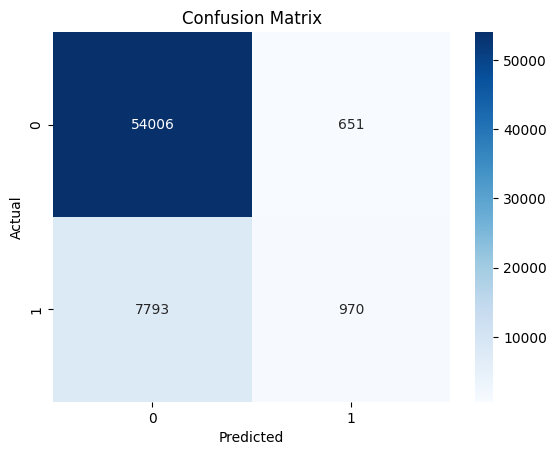

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#### Comparison against Dummy Classifier

To see if our model's any good, let's compare it against a dummy classifier, which will just predict that nobody has diabetes.

In [ ]:
# Generate predictions
y_pred_dummy = [0 for i in X_test] # preduct 0 for everything

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dummy))

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_dummy)
print(f"ROC-AUC: {roc_auc}")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93     54657
         1.0       0.00      0.00      0.00      8763

    accuracy                           0.86     63420
   macro avg       0.43      0.50      0.46     63420
weighted avg       0.74      0.86      0.80     63420

ROC-AUC: 0.5


c:\Users\Matthew Wanta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Matthew Wanta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Matthew Wanta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

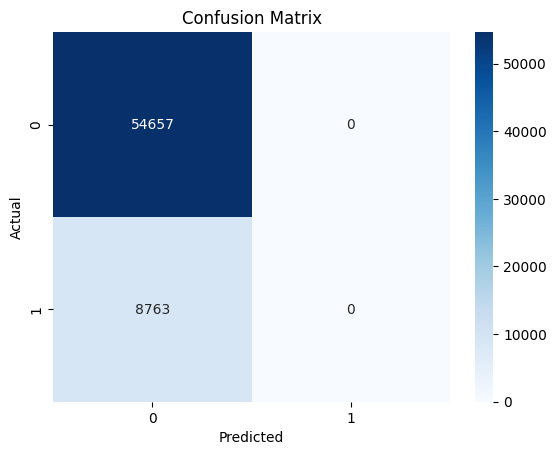

In [ ]:
cm = confusion_matrix(y_test, y_pred_dummy)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Ok, so for now, we barely beat the baseline. Future research will focus on beating this naive baseline, but for now, we move on.

### Training a Random Forest on the Full Dataset
Neural networks are far from the only classification model we can train. Let's try training instead on a random forest and try to beat our accuracy metric.

In [ ]:
# Import necessary libraries
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create the RandomForestClassifier model
model = RandomForestClassifier(random_state=42, n_jobs=10, verbose=3)

# Perform GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=10, scoring='accuracy', verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Evaluate the model on training and validation sets
train_accuracy = best_model.score(X_train, y_train)
val_accuracy = best_model.score(X_test, y_test)

# Print the results
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Save the best model to a file
joblib.dump(best_model, 'out/best_random_forest_model.pkl')

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 30building tree 2 of 30
building tree 3 of 30

building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=10)]: Done  22 out of  30 | elapsed:    3.7s remaining:    1.3s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:    4.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 30building tree 2 of 30
building tree 3 of 30

building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=10)]: Done  22 out of  30 | elapsed:    3.7s remaining:    1.3s


Training Accuracy: 0.8837275307473983
Validation Accuracy: 0.8667928098391674


[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:    3.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:    0.0s finished


['best_random_forest_model.pkl']

#### Evaluating Random Forest Performance

Below are the classification report and confusion matrix for our random forest trained on the entire dataset.

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.87

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93     54657
         1.0       0.60      0.11      0.18      8763

    accuracy                           0.87     63420
   macro avg       0.74      0.55      0.56     63420
weighted avg       0.84      0.87      0.82     63420



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:    0.0s finished


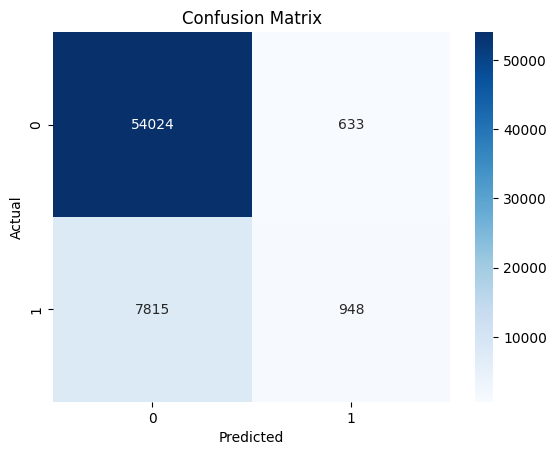

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Well, using a secondary approach seemed to work just as well, which is to say, not much better.

## Ensuring Input Diversity

### Building the Covering Dataset

Now, to the meat and potatoes of our approach. We need to convert a dataset into a covering dataset. Let's take another look at our original dataset.

In [13]:
ca_dataset = dataset.drop(columns=["Diabetes_binary"])
ca_response = dataset["Diabetes_binary"]
ca_dataset.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


First, let's examine the counts for each variable, which will be useful for determining whether the dataset meets the definition of a mixed-level covering dataset.

In [14]:
mlca_values = ca_dataset.nunique().tolist()
ca_dataset.nunique()

HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

It appears that BMI, MentlHlth, and PhysHlth are the three largest columns. Let's use `pd.qcut` for bucketing to reduce these.

In [31]:
n_splits = 5 # kinda arbitrary for now
categoricals = ["BMI", "MentHlth", "PhysHlth", "Age"]

ca_encoded = ca_dataset.copy()

for c in categoricals:
    ca_encoded[c] = pd.qcut(ca_dataset[c], q=n_splits, duplicates="drop")

ca_encoded = ca_encoded.apply(lambda col: pd.factorize(col)[0])

ca_encoded.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,1,0,1,...,1,1,1,1,1,1,0,1,1,1
2,0,0,0,2,1,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,2
3,0,1,0,2,1,0,0,1,1,0,...,0,0,2,1,1,1,0,2,2,3
4,0,0,0,1,1,0,0,1,1,0,...,0,0,2,1,1,1,0,2,3,4


Therefore, our input dataset can be represented as a mixed-level covering array whose values have the following properties:

In [ ]:
mlca_values = ca_encoded.nunique().to_dict()
ca_encoded.nunique()

HighBP                  2
HighChol                2
CholCheck               2
BMI                     5
Smoker                  2
Stroke                  2
HeartDiseaseorAttack    2
PhysActivity            2
Fruits                  2
Veggies                 2
HvyAlcoholConsump       2
AnyHealthcare           2
NoDocbcCost             2
GenHlth                 5
MentHlth                2
PhysHlth                2
DiffWalk                2
Sex                     2
Age                     5
Education               6
Income                  8
dtype: int64

Now, we need to create a covering array using the rows of our input dataset.

In [33]:
candidate_rows = ca_encoded.values.tolist()

Here's a covering array verifier, brought to you by the advanced technologies.

In [65]:
import itertools
import math

def is_a_covering_array(A, mlca_values, t):
    k = len(A[0])

    for col_combo in itertools.combinations(range(k), t):
        # Create a set to store unique t-tuples of values
        unique_tuples = set()
        for row in A:
            tuple_values = tuple(row[i] for i in col_combo)
            unique_tuples.add(tuple_values)

        num_combos = math.prod([mlca_values[col-1] for col in col_combo])
        
        if len(unique_tuples) < num_combos:
            return False
    return True

In [53]:
is_a_covering_array(candidate_rows, mlca_values, 3)

False

In [52]:
len(candidate_rows)

253680

Our dataset is covering for t=2, but not t=3, though it takes a little while to verify that fact.

To perform our experiment, we'll first need to generate a covering array from these candidate rows.

In [54]:
import random

def generate_covering_array(n, candidate_rows):
    """
    generates a covering array using rows of the dataset
    """
    n_iter = 1000

    for i in range(n_iter):
        A = random.sample(candidate_rows, n)
        if is_a_covering_array(A, mlca_values, 2):
            return A
    print(f"No CA found after {n_iter} tries")
    return False

In [55]:
# if not (A := generate_covering_array(40000, candidate_rows)):
#     print("failed")

Cool, so now we have a covering array. Let's write another function, then train the model on this subset.

In [66]:
def generate_covering_dataset(n, data):
    #mlca_values = data.nunique().tolist()

    while True:
        ca_subset = data.sample(n)

        ca_encoded = ca_subset.apply(lambda col: pd.factorize(col)[0])

        candidate_rows = ca_encoded.values.tolist()

        if is_a_covering_array(candidate_rows, mlca_values, 2):
            return ca_subset

In [60]:
ca_dataset.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Next we build a covering array with n=50,000 rows randomly. Note that we save and load A to a csv, as this can take a while to execute.

In [62]:
#A = generate_covering_dataset(50000, ca_dataset)
#A.to_csv("out/CA.csv") 

In [67]:
def covering_dataset_verifier(ca_subset):

    candidate_rows = ca_subset.values.tolist()

    if is_a_covering_array(candidate_rows, mlca_values, 2):
        return True

In [68]:
A = pd.read_csv("out/CA.csv")

covering_dataset_verifier(A)

True

### Training on the Covering Dataset

Now, we need to train the model on the subset of data.

In [71]:
# find all data not used in the creation of the covering subset
unused_data = ca_dataset[~ca_dataset.index.isin(A.index)]
val = unused_data.sample(10000)
test = unused_data[~unused_data.index.isin(val.index)].sample(10000)

# create and prepare a validation subset
X_val_small = preprocessor.transform(val)
y_val_small = ca_response.loc[val.index]

# create and prepare a test subset
X_test_small = preprocessor.transform(test)
y_test_small = ca_response.loc[test.index]
test.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
47809,0.0,1.0,1.0,31.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,4.0,20.0,26.0,1.0,0.0,9.0,4.0,1.0
234978,1.0,0.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,7.0
243407,0.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,3.0,0.0,30.0,1.0,1.0,8.0,4.0,6.0
102733,1.0,1.0,1.0,32.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,5.0,8.0
186690,0.0,0.0,1.0,31.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,4.0,30.0,0.0,1.0,1.0,7.0,3.0,6.0


In [75]:
# extract the values from the original dataset to make the covering dataset from the covering array
X_subset_train = ca_dataset.loc[A.index]
y_subset_train = ca_response.loc[A.index]

X_subset_train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [76]:
processed_x_subset_train = preprocessor.transform(X_subset_train)

Now, we train the model on the covering dataset.

In [77]:
# Build the model with regularization and dropout
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),  # L2 regularization
    BatchNormalization(),  # Batch normalization
    Dropout(0.5),  # Dropout with 50% rate

    Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),  # L2 regularization
    BatchNormalization(),  # Batch normalization
    Dropout(0.5),  # Dropout with 50% rate
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop if no improvement after 5 epochs
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
)

# Train the model with validation split
history = model.fit(
    processed_x_subset_train, y_subset_train,
    epochs=50,  # Increase epochs; early stopping will handle overtraining
    batch_size=32,
    validation_data=(X_val_small, y_val_small),
    callbacks=[early_stopping],  # Include early stopping
    verbose=1
)


Epoch 1/50


c:\Users\Matthew Wanta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - accuracy: 0.7374 - loss: 0.7801 - val_accuracy: 0.8606 - val_loss: 0.4819
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.8651 - loss: 0.4777 - val_accuracy: 0.8622 - val_loss: 0.4166
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.8662 - loss: 0.4047 - val_accuracy: 0.8619 - val_loss: 0.3714
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.8653 - loss: 0.3674 - val_accuracy: 0.8639 - val_loss: 0.3468
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8654 - loss: 0.3487 - val_accuracy: 0.8632 - val_loss: 0.3386
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.8663 - loss: 0.3392 - val_accuracy: 0.8641 - val_loss: 0.3361
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.8672 - loss: 0.3316 - val_accuracy: 0.8643 - val_loss: 0.3320
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.8657 - loss: 0.33

#### Evaluating the Model Trained on the Covering Dataset

Below are depicted the accuracies for the covering dataset.

In [78]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_small, y_test_small)
y_pred_small = model.predict(X_test_small)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.8647 - loss: 0.3215
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
Test Loss: 0.3170301914215088
Test Accuracy: 0.8683000206947327


### Training on a Random Forest

Much like as above, we now train on an alternative classification model.

In [84]:
# Import necessary libraries
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create the RandomForestClassifier model
model = RandomForestClassifier(random_state=42, n_jobs=10, verbose=3)

# Perform GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=10, scoring='accuracy', verbose=3)

# Fit the grid search to the training data
grid_search.fit(processed_x_subset_train, y_subset_train)

# Get the best model from the grid search
best_model_2 = grid_search.best_estimator_

# Fit the best model on the training data
best_model_2.fit(processed_x_subset_train, y_subset_train)

# Evaluate the model on training and validation sets
train_accuracy = best_model.score(processed_x_subset_train, y_subset_train)
val_accuracy = best_model.score(X_test_small, y_test_small)

# Print the results
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Save the best model to a file
joblib.dump(best_model_2, 'best_random_forest_mode_2l.pkl')

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


0.8627


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished


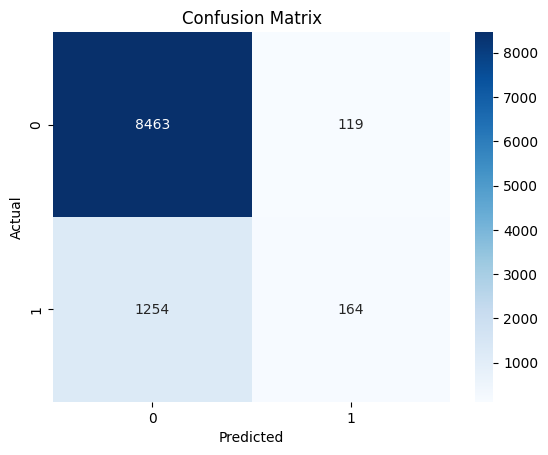

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_small = best_model_2.predict(X_test_small)
print(accuracy_score(y_test_small, y_pred_small))

cm = confusion_matrix(y_test_small, y_pred_small)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Initial Approach: Percent Covering

### Dataset Orientation and Initial Exploration

Our initial approach used different dataset involvuing housing prices. First, let's open our dataset, which comes from Kaggle at the following link: https://www.kaggle.com/datasets/harishkumardatalab/housing-price-prediction/data


In [4]:
import pandas as pd

dataset = pd.read_csv("data/Housing.csv")

dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Eventually, I want to see a plot of each variable against the other to get an idea of the relationship between each variable. However, this first requires a bti of pre-processing of the data. Primarily, this involves converting yes/no responses into binary values. 

In [5]:
binary_columns = ['mainroad','guestroom','basement','hotwaterheating','airconditioning', 'prefarea']

for col in binary_columns:
    dataset[col] = dataset[col].apply(lambda x: 0 if x == 'no' else 1)

dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


The only column left to convert is ```furnishingstatus```, which we'll likewise convert to a numerical value. And yes, later, we'll perform one-hot encoding.

In [6]:
furnishing_matrix = {
    "furnished":2,
    "semi-furnished":1,
    "unfurnished":0
}

dataset['furnishingstatus'] = dataset['furnishingstatus'].apply(lambda x: furnishing_matrix[x])

dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


Now, to get an idea of the relationships between each variable, let's use seaborn's built-in ```pairplot``` function.

In [7]:
import seaborn as sns

sns.pairplot(dataset)

KeyboardInterrupt: 

The most relevant to our course of inquiry is the diagonal line of histograms. Some variables are fairly evenly distributed, such as ```furnishingstatus```, while others are extremely imbalanced, such as ```hotwaterheating```.

Given the prevalence of certain variables over others, it's likely that a model trained on this data would be more accurate for data points that contain variables that show up more often, likely seeing worse performance on rarer variable occurences.

### Percent Covering of Total Input Space

Without grotesquely destroying the input data, there's no chance of creating a covering array. The best I can do is percent coverage, which still ensures input diversity.

In [30]:
import itertools
import math

def percent_covering(A, mlca_values, t):
    k = len(A[0])

    num_covered_interactions = 0
    total_covered_interactions = 0

    for col_combo in itertools.combinations(range(k), t):
        # Create a set to store unique t-tuples of values
        unique_tuples = set()
        for row in A:
            tuple_values = tuple(row[i] for i in col_combo)
            unique_tuples.add(tuple_values)

        num_combos = math.prod([mlca_values[col] for col in col_combo])

        num_covered_interactions += len(unique_tuples)
        total_covered_interactions += num_combos

    return num_covered_interactions / total_covered_interactions

In [31]:
def convert_datset_to_covering_array(dataset, numerical_features, n_splits=3):

    ca_encoded = dataset.copy()

    for c in numerical_features:
        ca_encoded[c] = pd.qcut(dataset[c], q=n_splits, duplicates="drop")

    ca_encoded = ca_encoded.apply(lambda col: pd.factorize(col)[0])

    return ca_encoded

In [32]:
ca_encoded = convert_datset_to_covering_array(dataset, numerical_features=["price"])
mlca_values = ca_encoded.nunique().tolist()
candidate_rows = ca_encoded.values.tolist()

In [33]:
percent_covering(candidate_rows, mlca_values, 2)

0.4321398834304746

Ok, not great. The baseline is 42% covering with `t=2`. Let's set a threshold and see how few rows we need to ensure it's covering. And since we can't really modify values within a row, the best we can do is randomly select rows. But again, let's first split into train and test: 

In [ ]:
import random

n_iter = 1000
trial_percent = []
t = 2
n_rows = 200

for i in range(n_iter):
    subset = random.sample(candidate_rows, k=n_rows)
    pc = percent_covering(subset, mlca_values, t)
    trial_percent.append(pc)

print(f"Best coverage: {max(trial_percent):.2%}")
print(f"Worst coverage: {min(trial_percent):.2%}")
print(f"Avg coverage: {sum(trial_percent)/len(trial_percent):.2%}")

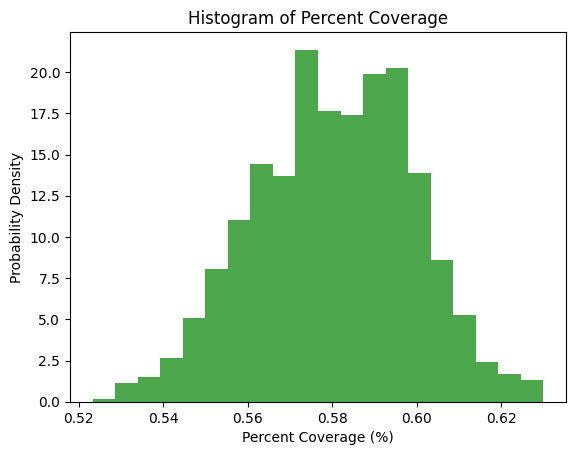

In [ ]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(trial_percent, bins=20, density=True, alpha=0.7, color='g')

# Customize the plot
plt.xlabel('Percent Coverage (%)')
plt.ylabel('Probability Density')
plt.title('Histogram of Percent Coverage')

# Show the plot
plt.show()

Exploration into the number of rows is a potential avenue forward. However, as for now, we'll limit it to 150. Most percent coverage variation stays within an 8% spread.

Now, for each subset, we'll fit a model to it, and we'll be able to plot its `mse` against its percent coverage.

In [ ]:
from tqdm import tqdm

n_iter = 200
n_rows = 200
t = 3

results = {}

X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=["price"]), dataset["price"], test_size=0.25)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test_processed = pd.DataFrame(preprocessor.transform(X_test).toarray())
y_test_processed = pd.Series(scaler_y.transform(y_test.values.reshape(-1, 1)).ravel())

n_splits = 4
ca_train = X_train.copy()
ca_train["area"] = pd.qcut(ca_train["area"], q=n_splits, labels=list(range(n_splits)))

mlca_values = ca_train.nunique().tolist()

ca_train = ca_train.values.tolist()

tf.get_logger().setLevel('ERROR')

for trial in range(n_iter):
    # take a n=150 subset of the train dataset
    X_train_subset = X_train.sample(n=min(150, len(X_train)))
    y_train_subset = y_train.loc[X_train_subset.index]
    
    ca_subset = [ca_train[i] for i in X_train_subset.index.tolist()]

    # calculate the percent coverage of the X_train_subset
    pc = percent_covering(ca_subset, mlca_values, t)

    X_train_subset_processed = pd.DataFrame(preprocessor.transform(X_train_subset).toarray())
    y_train_subset_processed = pd.Series(scaler_y.transform(y_train_subset.values.reshape(-1, 1)).ravel())

    # Build the neural network
    model = Sequential([
        Dense(32, activation='relu', input_dim=X_train_subset_processed.shape[1]),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Linear activation for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.05), loss='mse', metrics=['mse'])

    # Train the model
    history = model.fit(X_train_subset_processed, y_train_subset_processed, validation_data=(X_test_processed, y_test_processed), 
                        epochs=50, batch_size=32, verbose=0)
    
    loss, mse = model.evaluate(X_test_processed, y_test_processed, verbose=0) 

    results[trial] = {"percent_coverage": pc,
                      "loss":loss,
                      "mse":mse}


C:\Users\matthew.wanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\matthew.wanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\matthew.wanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\P

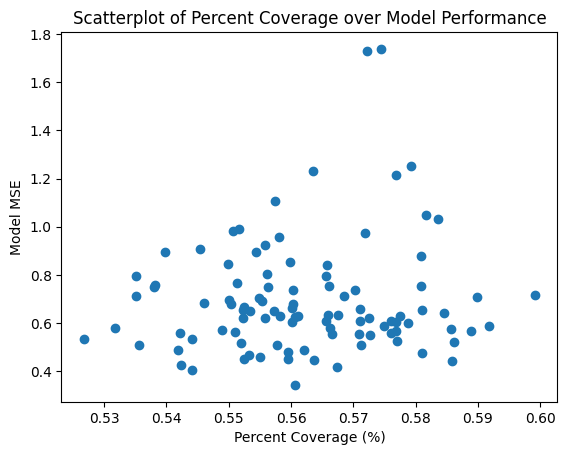

In [ ]:
# Create a plot
x = [r["percent_coverage"] for r in results.values()]
y = [r["mse"] for r in results.values()]

plt.scatter(x, y)

# Customize the plot
plt.xlabel('Percent Coverage (%)')
plt.ylabel('Model MSE')
plt.title('Scatterplot of Percent Coverage over Model Performance')

# Show the plot
plt.show()

In [ ]:
A = random.sample(candidate_rows, 50000)

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create the RandomForestClassifier model
model = RandomForestClassifier(random_state=42, n_jobs=10, verbose=3)

# Perform GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=10, scoring='accuracy', verbose=3)

# Fit the grid search to the training data
grid_search.fit(processed_x_subset_train, y_subset_train)

# Get the best model from the grid search
best_model_2 = grid_search.best_estimator_

# Fit the best model on the training data
best_model_2.fit(processed_x_subset_train, y_subset_train)

# Evaluate the model on training and validation sets
train_accuracy = best_model.score(processed_x_subset_train, y_subset_train)
val_accuracy = best_model.score(X_test_small, y_test_small)

# Print the results
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Save the best model to a file
joblib.dump(best_model, 'best_random_forest_mode_2l.pkl')

## Extant Percent Covering

Instead of finding all interactions across the input space, instead we try to find the percentage of interactions present in the subset over the total number of interactions that actually exist in the dataset itself. 

### Rehashing Previous Work

We're pretty far away from all the preceding code, so let's just briefly use the advanced technologies to concisely reprocess our dataset.

First, load in the dataset.

In [2]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

# display the number of entries and columsn in the dataset
print(dataset.shape)
dataset.head()

(253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Next, import the relevant libraries.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

As we're trying to predict diabetes diagnoses, we'll first drop the ```Diabetes_binary``` column to build our explanatory variables ```X``` and response variable ```y```. We then further subdivide the explanatory variables into numerical and categorical features.

In [4]:
# Define features and target
X = dataset.drop(columns=['Diabetes_binary'])  # Features
y = dataset['Diabetes_binary']  # Target variable

# Separate numerical and binary columns
numerical_features = ['BMI']
categorical_features = ['GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', ]


We then use ```sklearn```'s built-in ```ColumnTransformer``` to scale the numerical and categorical variables appropiately. Using ```StandardScaler```, we scale all values between ```0``` and `1`, and use `OneHotEncoder` on categorial variables.

In [5]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features),
    ],
    remainder='passthrough' # let binary variables through unaltered
)

# Apply preprocessing to features
X_preprocessed = preprocessor.fit_transform(X)

Finally, we split the data into test and train subsets.

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.25, random_state=42)
print(X_train.shape, y_train.shape)

(190260, 109) (190260,)


### Building the Covering Dataset

In [7]:
ca_dataset = dataset.copy()
ca_dataset.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


We now define a function to convert a dataset into a proto-covering array (a potential covering array).

In [8]:
def convert_datset_to_covering_array(dataset, categorical_features, n_splits=3):

    ca_encoded = dataset.copy()

    for c in categorical_features:
        ca_encoded[c] = pd.qcut(dataset[c], q=n_splits, duplicates="drop")

    ca_encoded = ca_encoded.apply(lambda col: pd.factorize(col)[0])

    return ca_encoded

ca_encoded = convert_datset_to_covering_array(ca_dataset, categorical_features = ["BMI", "MentHlth", "PhysHlth"], n_splits=8)
ca_encoded.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,0,0,0,1,0,...,1,1,1,1,1,1,0,1,1,1
2,0,0,0,0,2,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,2
3,0,0,1,0,3,1,0,0,1,1,...,0,0,2,1,1,1,0,2,2,3
4,0,0,0,0,4,1,0,0,1,1,...,0,0,2,2,1,1,0,2,3,4


Again, instead of finding all interactions across the input space, we try to find the percentage of interactions present in the subset over the total number of interactions that actually exist in the dataset itself.

In [9]:
import itertools

def get_all_interactions(A, t):
    """
    returns a dict, where each row index has its stored saved interactions
    """
    k = len(A[0])

    # Create a set to store unique t-tuples of values across the entire CA
    all_interactions = {x:set() for x in range(len(A))}

    for col_combo in itertools.combinations(range(k), t):
        
        for i, row in enumerate(A):
            tuple_values = (col_combo, tuple(row[i] for i in col_combo))
            all_interactions[i].add(tuple_values)

    return all_interactions

def extant_percent_covering(A_interaction_dict, subset, t):
    all_interactions = set(A_interaction_dict[i] for i in A_interaction_dict)
    interaction_subset = set(A_interaction_dict[i] for i in subset.index)
    
    return len(interaction_subset) / len(all_interactions)

Next, we generate a partial covering array in the following manner. We sample rows of A without replacement and see if they add any new interactions. If they do, keep them, else, discard them.

In [10]:
A_list = ca_encoded.values.tolist()
all_interactions = get_all_interactions(A_list, 2)
subset_interactions = set()

In [11]:
def generate_covering_dataset(A: pd.DataFrame, n, t):

    A_list = ca_encoded.values.tolist()
    all_interactions = get_all_interactions(A_list, 2)
    subset_interactions = set()

    B = A.copy()
    C = B.sample(1)
    B = B.drop(C.index)

    for i in range(n):
        # sample a random row
        candidate_row = B.sample(1)

        # if the row adds new interactions to the model, add it
        if not all_interactions[candidate_row.index[0]].issubset(subset_interactions):
            C.loc[candidate_row.index[0]] = candidate_row.iloc[0]            
    
    return C, all_interactions

D, all_dict = generate_covering_dataset(ca_encoded, 10000, 2)

Let's analyze this dataset for values of t from 2 to 6 and see how covering it is for each. First, we'll provide a variant of the function to allow for cached values.

In [12]:
def generate_covering_dataset_cached(all_interactions, n, t):

    subset_interactions = set()

    B = A.copy()
    C = B.sample(1)
    B = B.drop(C.index)

    while C.shape[0] < n:
        # sample a random row
        candidate_row = B.sample(1)

        # if the row adds new interactions to the model, add it
        if not all_interactions[candidate_row.index[0]].issubset(subset_interactions):
            C.loc[candidate_row.index[0]] = candidate_row.iloc[0]            
    
    return C, all_interactions

: 

Now we'll calculate the interaction dicts for each value of t

In [2]:
import tqdm

covering_datasets = []
interactions_dict_t = {}

for t in tqdm.tqdm(range(2, 5)):
    A_list = ca_encoded.values.tolist()
    all_interactions = get_all_interactions(A_list, t)

    interactions_dict_t[t] = all_interactions

  0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'ca_encoded' is not defined

In [ ]:
import json

with open("refs/cached_interaction_dicts.json", "wb") as f:
    data = {i+1:x for i, x in enumerate(interactions_dict_t)}
    json.dump(data, f)

## Training Classification Models

### Training a Neural Network
With this model cleaned, we're able to implement a neural network to train on the data and hopefully, learn associations within the data.

We then build and compile the neural network.

In [ ]:
# Build the model with regularization and dropout
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),  # L2 regularization
    BatchNormalization(),  # Batch normalization
    Dropout(0.5),  # Dropout with 50% rate

    Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),  # L2 regularization
    BatchNormalization(),  # Batch normalization
    Dropout(0.5),  # Dropout with 50% rate
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop if no improvement after 5 epochs
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
)

# Train the model with validation split
history = model.fit(
    X_train, y_train,
    epochs=50,  # Increase epochs; early stopping will handle overtraining
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],  # Include early stopping
    verbose=1
)



Epoch 1/50


c:\Users\Matthew Wanta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1759/4757 ━━━━━━━━━━━━━━━━━━━━ 2s 783us/step - accuracy: 0.7610 - loss: 0.7281

KeyboardInterrupt: 